### Necessary import

In [1]:
import os
import copy
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

from lib.model.base import Base
from lib.utils import set_seed,sample_indices,get_experiment_dir,to_numpy
from lib.augmentations import apply_augmentations
from lib.distance.w1_distance import W1_distance,W1_dist_PathSpace,W1_dist_SigSpace
from lib.datasets import get_stock_price, train_test_split
from lib.network import get_generator, get_discriminator
from lib.test_metrics import get_standard_test_metrics
from lib.plot import plot_test_metrics

### Hyperparameter

In [2]:
wgan_config = {
    'batch_size' : 16,
    'epoch' : 512,
    'lr_generator' : 5e-4,
    'lr_discriminator' : 5e-4,
    'discriminator_steps_per_generator_step' : 3,
    'device' : 'cuda:0' if torch.cuda.is_available() else 'cpu',
}
data_config = {
    'ticker' : '^GSPC',
    'interval' : '1mo',
    'column' : 0,  #Open
    'window_size' : 3,
    'dir' : 'datasets',
    'subdir' : 'stock',
}
D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
G_config = {
    "generator_type": "LSTM",
    "hidden_dim": 50,
    "n_layers": 2,
    "init_fixed": True,
    "input_dim": 5
}
print(wgan_config['device'])

set_seed(2024)

cuda:0


### Load data

In [3]:
x_real_rolled = get_stock_price(data_config)
x_real_rolled = x_real_rolled.to(wgan_config['device'])
print('Total data: ', list(x_real_rolled.shape))

x_real_train, x_real_test = train_test_split(x_real_rolled, train_test_ratio=0.8, device=wgan_config['device'])
x_real_dim: int = x_real_rolled.shape[2]
wgan_input_dim = x_real_dim * data_config['window_size']

print("D input dim: {}".format(wgan_input_dim)) # D output dim is always 1
print("G output dim: {}".format(x_real_dim)) 

Rolled data for training, shape torch.Size([286, 3, 1])
Total data:  [286, 3, 1]
D input dim: 3
G output dim: 1


### WGAN-GP

In [4]:
def set_requires_grad(model, requires_grad):
    for p in model.parameters():
        p.requires_grad_(requires_grad)

In [5]:
class WGAN(nn.Module):
    def __init__(self, D, G, batch_size, epoch, discriminator_steps_per_generator_step, lr_discriminator, test_metrics_train, test_metrics_test, 
                 lr_generator, x_real: torch.Tensor, lambda_reg=10., **kwargs):
        if kwargs.get('augmentations') is not None:
            self.augmentations = kwargs['augmentations']
            del kwargs['augmentations']
        else:
            self.augmentations = None
        super(WGAN, self).__init__()

        self.D = D
        self.G = G
        self.G_optimizer = torch.optim.Adam(G.parameters(), lr=lr_generator, betas=(0, 0.9))
        self.D_optimizer = torch.optim.Adam(D.parameters(), lr=lr_discriminator, betas=(0, 0.9))
        
        self.batch_size = batch_size
        self.epoch = epoch
        self.discriminator_steps_per_generator_step = discriminator_steps_per_generator_step
        self.lr_discriminator = lr_discriminator
        self.lr_generator = lr_generator
        if self.augmentations is not None:
            self.x_real = apply_augmentations(x_real, self.augmentations)
        else:
            self.x_real = x_real
        self.lambda_reg = lambda_reg
        self.losses_history = defaultdict(list)
        self.best_cov_err = None

        self.test_metrics_train = test_metrics_train
        self.test_metrics_test = test_metrics_test
        
    def fit(self, device):
        self.G.to(device)
        self.D.to(device)
        pbar = tqdm(range(self.epoch))
        for _ in pbar:
            self.step(device)
            pbar.set_description(
                "G_loss {:1.6e} D_loss {:1.6e}".format(self.losses_history['G_loss'][-1],
                                                                       self.losses_history['D_loss'][-1],))

    def step(self, device):
        
        for i in range(self.discriminator_steps_per_generator_step):
            # Generate x_fake
            indices = sample_indices(self.x_real.shape[0], self.batch_size, wgan_config['device'])
            x_real_batch = self.x_real[indices].to(device)
            # torch.no_grad() is a context-manager that disabled gradient calculation for wrapped code.
            with torch.no_grad():
                x_fake = self.G(batch_size=self.batch_size, n_lags=self.x_real.shape[1], device=device)
                if self.augmentations is not None:
                    x_fake = apply_augmentations(x_fake, self.augmentations)

            D_loss = self.D_train(x_fake, x_real_batch)
            if i == 0:
                self.losses_history['D_loss'].append(D_loss)
        G_loss = self.G_train(device)
        self.losses_history['G_loss'].append(G_loss)

    def G_train(self, device):

        set_requires_grad(self.G, True)

        x_fake = self.G(batch_size=self.batch_size, n_lags=self.x_real.shape[1], device=device)
        if self.augmentations is not None:
            x_fake = apply_augmentations(x_fake, self.augmentations)

        self.G.train()
        self.G_optimizer.zero_grad()
        d_fake = self.D(x_fake)
        self.D.train()
        # G_loss = self.compute_loss(d_fake, 1)
        G_loss = -d_fake.mean()
        G_loss.backward()
        self.G_optimizer.step()
        self.evaluate(x_fake)

        set_requires_grad(self.G, False)
        # return G_loss.item()
        return G_loss.item()

    def D_train(self, x_fake, x_real):

        set_requires_grad(self.D, True)

        self.D.train()
        self.D_optimizer.zero_grad()

        # Change here
        x_real.requires_grad_()
        x_fake.requires_grad_()
        W1_dist = W1_dist_PathSpace(self.D,x_real=x_real,x_fake=x_fake, lambda_reg=self.lambda_reg)
        total_loss = W1_dist.get_dist(batch_size=self.batch_size)
        total_loss.backward()

        self.D_optimizer.step()

        # Set gradient to False
        set_requires_grad(self.D, False)

        return total_loss.item()
    def evaluate(self, x_fake):
        # self.losses_history['time'].append(time.time() - self.init_time)
        with torch.no_grad():
            for test_metric in self.test_metrics_train:
                test_metric(x_fake)
                loss = to_numpy(test_metric.loss_componentwise)
                if len(loss.shape) == 1:
                    loss = loss[..., None]
                self.losses_history[test_metric.name + '_train'].append(loss)
            for test_metric in self.test_metrics_test:
                test_metric(x_fake)
                loss = to_numpy(test_metric.loss_componentwise)
                if len(loss.shape) == 1:
                    loss = loss[..., None]
                self.losses_history[test_metric.name + '_test'].append(loss)
        # self.best_cov_err = self.losses_history['covariance_test'][-1].item() if self.best_cov_err == None else self.best_cov_err
        # if self.losses_history['covariance_test'][-1].item() < self.best_cov_err:
        #     self.best_G = copy.deepcopy(self.G.state_dict())
        #     self.best_cov_err = self.losses_history['covariance_test'][-1].item()

### Set discriminator and generator

In [6]:
D_config.update(input_dim=wgan_input_dim)
print(D_config)
G_config.update(output_dim=x_real_dim)
print(G_config)

D = get_discriminator(**D_config).to(wgan_config['device'])
G = get_generator(**G_config).to(wgan_config['device'])

{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 3}
{'generator_type': 'LSTM', 'hidden_dim': 50, 'n_layers': 2, 'init_fixed': True, 'input_dim': 5, 'output_dim': 1}


In [7]:
test_metrics_train = get_standard_test_metrics(x_real_train)
test_metrics_test = get_standard_test_metrics(x_real_test)

print(test_metrics_train)
print(test_metrics_test)

[SigW1Loss()]
[SigW1Loss()]


In [8]:
WGAN = WGAN(D, G, 
                   x_real=x_real_rolled, 
                   test_metrics_train=test_metrics_train,
                   test_metrics_test=test_metrics_test,
                   **wgan_config
)
WGAN.fit(device=wgan_config['device'])

G_loss -5.363868e-01 D_loss 1.134320e-01: 100%|██████████| 512/512 [00:04<00:00, 103.96it/s] 


Text(0.5, 1.0, 'G loss')

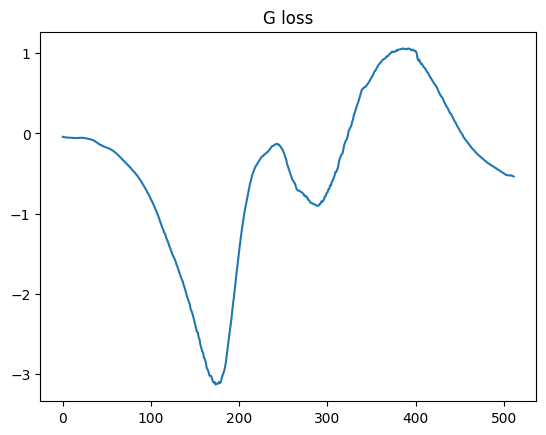

In [9]:
plt.plot(WGAN.losses_history['G_loss'])
plt.title("G loss")

Text(0.5, 1.0, 'D loss')

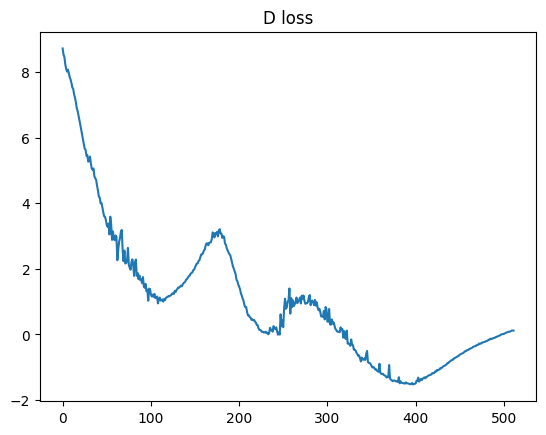

In [10]:
plt.plot(np.array(WGAN.losses_history['D_loss']))
plt.title("D loss")

In [11]:
experiment_dir = get_experiment_dir("^GSPC", "LSTM", "ResNN", 'WGAN', 2024)
loss_history = loss_history = os.path.join(experiment_dir, 'LossHistory')
os.makedirs(loss_history, exist_ok=True)


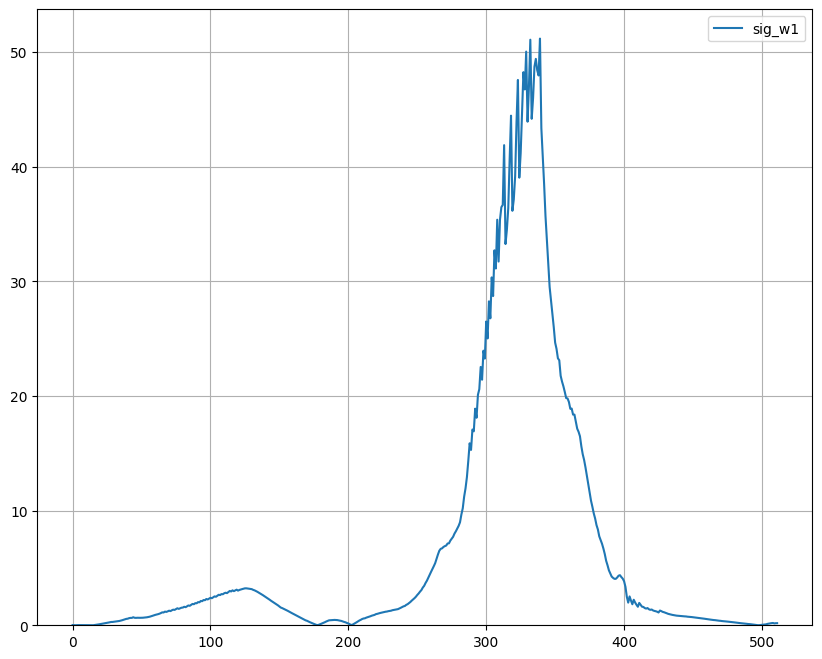

In [12]:
plot_test_metrics(WGAN.test_metrics_train, WGAN.losses_history, 'train')

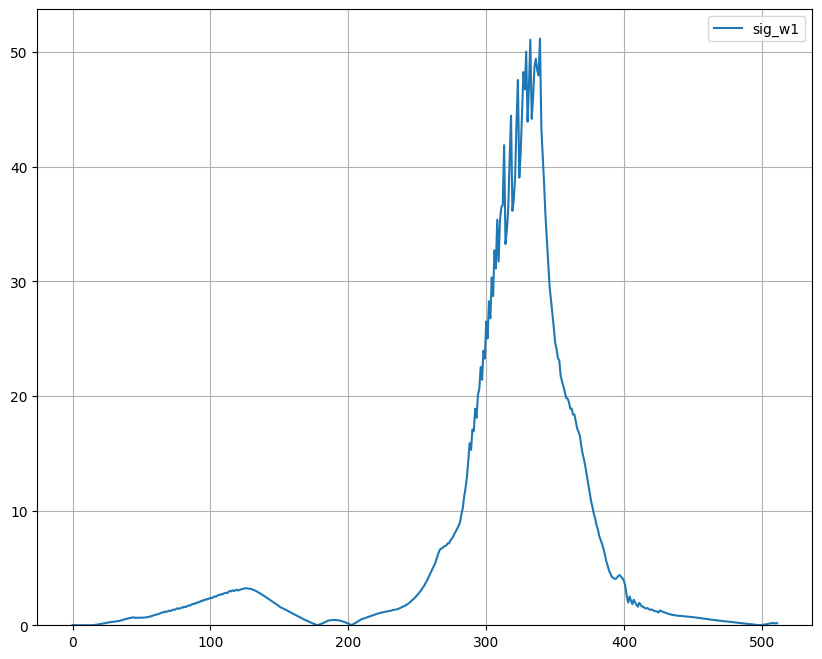

In [13]:
plot_test_metrics(WGAN.test_metrics_train, WGAN.losses_history, 'test')

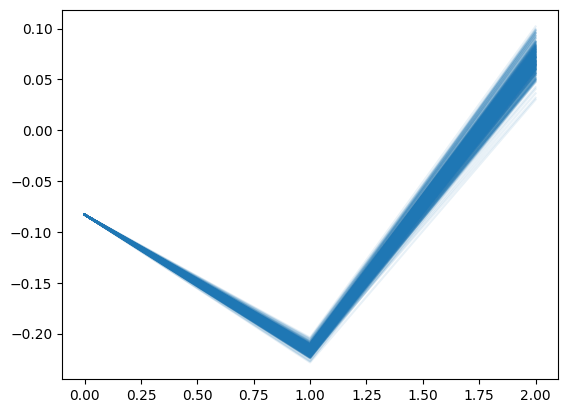

In [14]:
with torch.no_grad():
    x_fake = G(1024, data_config['window_size'], wgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(x_fake[:400, :, i]).T, 'C%s' % i, alpha=0.1)